#  Обратное распространение ошибки

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* http://cs231n.stanford.edu/handouts/linear-backprop.pdf
* https://www.adityaagrawal.net/blog/deep_learning/bprop_fc
* https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [1]:
# !pip install torchtyping

In [2]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

## Задачи для совместного разбора

1\. Реализуйте обратное распространение ошибки для модели нейрона с квадратичной функцией потерь при условии, что на вход нейрону поступает вектор `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

In [3]:
class Neuron:
    def __init__(self, n_features: int, bias: float, requires_grad: bool = False) -> None:
        # <создать атрибуты объекта weights и bias>
        self.weights: TensorType["n_features"] = th.rand(n_features, requires_grad=requires_grad)
        self.bias: Scalar = th.tensor(bias, requires_grad=requires_grad)

    @typechecked
    def forward(self, inputs: TensorType["n_features"]) -> Scalar:
        return inputs @ self.weights + self.bias

    def backward(self, inputs: TensorType["n_features"], dnext: Scalar):
      self.dweights = dnext * inputs
      self.dbias = dnext
      self.dinputs = dnext * self.weights


In [4]:
class Loss:
    def forward(
        self,
        y_pred: Scalar,
        y_true: Scalar
    ) -> Scalar:
        return (y_pred - y_true)**2

    def backward(self, y_pred: Scalar, y_true: Scalar) -> Scalar:
      self.dinput = 2 * (y_pred - y_true)

In [5]:
neuron = Neuron(n_features=2, bias=0.0, requires_grad=True)
criterion = Loss()

inputs = th.tensor([2.0, 3.0])
y_true = th.tensor(10)

# forward pass
y_pred = neuron.forward(inputs)
loss = criterion.forward(y_pred, y_true)

# backprop
criterion.backward(y_pred, y_true)
neuron.backward(inputs, criterion.dinput)

In [6]:
loss

tensor(54.7894, grad_fn=<PowBackward0>)

In [7]:
criterion.dinput

tensor(-14.8040, grad_fn=<MulBackward0>)

In [8]:
neuron.dweights

tensor([-29.6079, -44.4119], grad_fn=<MulBackward0>)

In [9]:
neuron.dbias

tensor(-14.8040, grad_fn=<MulBackward0>)

In [10]:
loss.backward()

In [11]:
neuron.weights.grad

tensor([-29.6079, -44.4119])

In [12]:
neuron.bias.grad

tensor(-14.8040)

In [13]:
loss

tensor(54.7894, grad_fn=<PowBackward0>)

2\. Настройте модель нейрона, используя метод стохастического градиентного спуска и собственную реализацию обратного распространения ошибки.

In [14]:
from sklearn.datasets import make_regression
import numpy as np

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [15]:
import numpy as np

In [16]:
neuron = Neuron(n_features=4, bias=0.0, requires_grad=False)
criterion = Loss()
lr = 0.1

for epoch in range(3):
    losses = []
    for x_i, y_i in zip(X, y):
        y_pred = neuron.forward(x_i)
        loss_i = criterion.forward(y_pred, y_i)
        losses.append(loss_i.item())

        criterion.backward(y_pred, y_i)
        neuron.backward(x_i, criterion.dinput)

        neuron.weights -= lr * neuron.dweights
        neuron.bias -= lr * neuron.dbias
    print(f"{epoch} {np.mean(losses)}")

0 607.4403791873248
1 7.900653867068286e-05
2 8.870366663416007e-11


In [17]:
neuron.weights

tensor([ 5.6376, 86.4722, 27.3407, 41.4820])

In [18]:
neuron.bias

tensor(0.5000)

In [19]:
coef

array([ 5.63754967, 86.47223763, 27.34070719, 41.48195023])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Реализуйте обратное распространение ошибки для модели нейрона с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`. Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{0} \\
w_{1} \\
\vdots \\
w_{m} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$L = \frac{1}{k}\sum_{k}{(\hat{y_k}-y_k)^2}$$

$$\nabla_{\hat{\mathbf{Y}}} L=\begin{bmatrix}
\frac{\partial L}{\partial \hat{y_1}} \\
\frac{\partial L}{\partial \hat{y_2}} \\
\vdots \\
\frac{\partial L}{\partial \hat{y_k}} \\
\end{bmatrix} = \frac{2}{k}\begin{bmatrix}
\hat{y_1} - y_1 \\
\hat{y_2} - y_2 \\
\vdots \\
\hat{y_k} - y_k \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\nabla_{\hat{\mathbf{Y}}} L}$$

- [ ] Проверено на семинаре

In [20]:
class NeuronBatch:
    def __init__(self, n_features: int, seed: int | None = None, grad: bool = False, lr: float = 0.01) -> None:
        if seed is not None:
            th.manual_seed(seed)
        self.weights: TensorType['n_features_with_bias', 1] = th.rand(n_features+1, requires_grad=grad)
        self.lr = lr

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        return th.cat([th.ones((inputs.shape[0], 1)), inputs], dim=1)

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", 1]:
        inputs = self.add_ones_col(inputs)
        return inputs @ self.weights

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", 1]) -> None:
        inputs = self.add_ones_col(inputs)
        self.dweights: TensorType["n_features_with_bias", 1] = inputs.T @ dnext
        self.weights: TensorType['n_features_with_bias', 1] = self.weights - self.lr * self.dweights
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return self.forward(*args, **kwds)

In [21]:
class MSELoss:
    def forward(self, y_pred: TensorType['batch', 1], y_true: TensorType['batch', 1]) -> Scalar:
        if y_true.dim() > 1:
            y_true = y_true.squeeze()
        return th.mean((y_pred - y_true)**2)

    def backward(self, y_pred: TensorType['batch', 1], y_true: TensorType['batch', 1]) -> None:
        if y_true.dim() > 1:
            y_true = y_true.squeeze()
        return 2*(y_pred - y_true) / y_true.shape[0]
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return self.forward(*args, **kwds)

Обучение модели

In [22]:
neuron = NeuronBatch(n_features=2, grad=True)
criterion = MSELoss()

inputs = th.rand((20, 2))*10
y_true = inputs[:, 0].clone().detach()*10 - 55

for epoch in range(5000):
    y_pred = neuron.forward(inputs)
    loss = criterion.forward(y_pred, y_true)

    dinput = criterion.backward(y_pred, y_true)
    neuron.backward(inputs, dinput)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.6f}")
loss, y_pred

Epoch 0, Loss: 840.688843
Epoch 500, Loss: 36.593346
Epoch 1000, Loss: 3.888474
Epoch 1500, Loss: 0.413195
Epoch 2000, Loss: 0.043906
Epoch 2500, Loss: 0.004666
Epoch 3000, Loss: 0.000496
Epoch 3500, Loss: 0.000053
Epoch 4000, Loss: 0.000006
Epoch 4500, Loss: 0.000001


(tensor(8.0100e-08, grad_fn=<MeanBackward0>),
 tensor([  9.3240, -27.1285,  23.4479, -30.8095,  22.1855,  26.6414,  15.5568,
          42.6410,  12.7055, -32.9042,  40.5202, -46.0570, -34.7062, -20.7781,
         -40.0410,  22.7845, -34.4924,  16.9220, -24.6288, -21.6843],
        grad_fn=<MvBackward0>))

Проверка равенства градиентов

In [23]:
neuron = NeuronBatch(n_features=2, grad=True)
criterion = MSELoss()

y_pred = neuron.forward(inputs)
loss = criterion.forward(y_pred, y_true)

loss.backward()
grad_autograd = neuron.weights.grad.detach().clone()

dinput = criterion.backward(y_pred, y_true)
neuron.backward(inputs, dinput)
grad_manual = neuron.dweights.detach().clone()

_eq = th.allclose(grad_manual, grad_autograd, atol=1e-7)
print(f'Градиенты совпадают {_eq}')

Градиенты совпадают True


Построение аналогичной модели с помощью torch

In [24]:
from torch import nn

class ThNeuron(nn.Module):
    def __init__(self, n_features: int, lr: float = 0.01):
        super(ThNeuron, self).__init__()
        self.linear = nn.Linear(n_features, 1, bias=True)
        self.lr = lr

    def forward(self, inputs: th.Tensor) -> th.Tensor:
        return self.linear(inputs)
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return super().__call__(*args, **kwds)

In [25]:
neuron = NeuronBatch(n_features=2, seed=42, grad=True)
thneuron = ThNeuron(n_features=2, lr=0.01)

with th.no_grad():
    thneuron.linear.weight.copy_(neuron.weights[1:].t())
    thneuron.linear.bias.copy_(neuron.weights[0])

criterion_manual = MSELoss()
criterion_autograd = nn.MSELoss()

inputs = th.rand((10, 2)) * 10
y_true = inputs[:, 0].clone().detach() * 10 - 55

In [26]:
y_pred_manual = neuron.forward(inputs)
y_pred_autograd = thneuron(inputs).squeeze(1)
_eq = th.allclose(y_pred_manual, y_pred_autograd, atol=1e-7)
print(f'Предсказания одинаковы: {_eq}')

Предсказания одинаковы: True


In [27]:
loss_manual = criterion_manual.forward(y_pred_manual, y_true)
loss_autograd = criterion_autograd(y_pred_autograd, y_true)
_eq = th.allclose(y_pred_manual, y_pred_autograd, atol=1e-7)
print(f'Ошибки одинаковы: {_eq}')

Ошибки одинаковы: True


In [28]:
dinput = criterion_manual.backward(y_pred_manual, y_true)
neuron.backward(inputs, dinput)
grad_manual = neuron.dweights.detach()

loss_autograd.backward()
thneuron.linear.weight.grad, thneuron.linear.bias.grad
grad_autograd = th.cat([
    thneuron.linear.bias.grad.unsqueeze(0), 
    thneuron.linear.weight.grad.t().reshape(-1,1)
], dim=0).squeeze(1)
_eq = th.allclose(grad_manual, grad_autograd, atol=1e-7) 
print(f'Градиенты одинаковы: {_eq}')

Градиенты одинаковы: True


<p class="task" id="2"></p>

2\. Настройте модель нейрона, используя метод мини-пакетного градиентного спуска.

Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [29]:
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [30]:
neuron = NeuronBatch(n_features=4, grad=True, lr=0.01)
criterion = MSELoss()

In [31]:
dataset = TensorDataset(X, y)

In [32]:
for epoch in range(1501):
    losses = []
    for X, y in DataLoader(dataset, batch_size=20, shuffle=True):
        y_pred = neuron.forward(X)
        loss_i = criterion.forward(y_pred, y)
        losses.append(loss_i.item())

        dinput = criterion.backward(y_pred, y)
        neuron.backward(X, dinput)
    
    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss: {np.mean(losses):.6f}')

Epoch 0, Loss: 8736.657617
Epoch 250, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 750, Loss: 0.000000
Epoch 1000, Loss: 0.000000
Epoch 1250, Loss: 0.000000
Epoch 1500, Loss: 0.000000


In [33]:
neuron_coef = neuron.weights.detach()
neuron_coef

tensor([ 0.5000,  5.6375, 86.4721, 27.3407, 41.4819])

In [34]:
_eq = th.allclose(
    th.tensor(
        np.concat([[0.5], coef]),
        dtype=th.float32
    ), neuron_coef, atol=1e-7,
)
print(f'Коэффициенты одинаковы: {_eq}')

Коэффициенты одинаковы: True


<p class="task" id="3"></p>

3\. Реализуйте обратное распространение ошибки для модели полносвязного слоя с функцией потерь MSE при условии, что на вход нейрону поступает пакет (двумерный тензор) `inputs`.  Проверьте корректность вычисления градиентов, воспользовавшись возможностями по автоматическому дифференцированию `torch`.

Обратите внимание, что вам потребуются оба градиента $ \boldsymbol{\nabla_{\mathbf{W}} L }$ и $\boldsymbol{\nabla_{\mathbf{X}} L}$ для распространения ошибки с несколькими слоями.

$$\mathbf{X} = \begin{bmatrix}
x_{10} & x_{11} & \ldots & x_{1m} \\
x_{20} & x_{21} & \ldots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{k0} & x_{k1} & \ldots & x_{km} \\
\end{bmatrix}
\mathbf{Y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
y_{k} \\
\end{bmatrix}
\mathbf{W} = \begin{bmatrix}
w_{01} & w_{02} & \ldots & w_{0n} \\
w_{11} & w_{12} & \ldots & w_{1n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \ldots & w_{mn} \\
\end{bmatrix}$$

$$\hat{\mathbf{Y}} = \mathbf{X}\times \mathbf{W}$$

$$\nabla_{\hat{\mathbf{Y}}} L = \begin{bmatrix}
\frac{\partial L}{\partial \hat{y_{11}}} & \ldots & \frac{\partial L}{\partial \hat{y_{1n}}} \\
\vdots & \vdots & \vdots \\
\frac{\partial L}{\partial \hat{y_{k1}}} & \ldots & \frac{\partial L}{\partial \hat{y_{kn}}} \\
\end{bmatrix}$$

$$\boldsymbol{\nabla_{\mathbf{W}} L = \mathbf{X}^T\times \nabla_{\hat{\mathbf{Y}}} L}$$
$$\boldsymbol{\nabla_{\mathbf{X}} L = \nabla_{\hat{\mathbf{Y}}} L\times \mathbf{W}^T}$$

- [ ] Проверено на семинаре

In [35]:
class Linear:
    def __init__(self, n_features: int, n_neurons: int, seed: int | None = None, grad: bool = False, lr: float = 0.01) -> None:
        if seed is not None:
            th.manual_seed(seed)
        self.weights: TensorType['n_features_with_bias', "n_neurons"] = th.rand((n_features+1, n_neurons), requires_grad=grad)
        self.lr = lr

    def add_ones_col(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features_with_bias"]:
        return th.cat([th.ones((inputs.shape[0], 1)), inputs], dim=1)

    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_neurons"]:
        inputs = self.add_ones_col(inputs)
        return inputs @ self.weights

    def backward(self, inputs: TensorType["batch", "n_features"], dnext: TensorType["batch", "n_neurons"]):
        inputs = self.add_ones_col(inputs)
        self.dweights: TensorType["n_features_with_bias", "n_neurons"] = inputs.T @ dnext
        self.weights: TensorType['n_features_with_bias', "n_neurons"] = self.weights - self.lr * self.dweights
        self.dinputs = dnext @ self.weights.T
        return self.dinputs[:, 1:]
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return self.forward(*args, **kwds)

In [36]:
class MSELoss:
    def forward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> Scalar:
        return th.mean((y_pred - y_true)**2)

    def backward(self, y_pred: TensorType["batch", "n_neurons"], y_true: TensorType["batch", "n_neurons"]) -> None:
        return 2*(y_pred - y_true) / y_true.shape[0]
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return self.forward(*args, **kwds)

Проверка равенства градиентов

In [37]:
neuron = NeuronBatch(n_features=2, grad=True)
criterion = MSELoss()

y_pred = neuron.forward(inputs)
loss = criterion.forward(y_pred, y_true)

loss.backward()
grad_autograd = neuron.weights.grad.detach().clone()

dinput = criterion.backward(y_pred, y_true)
neuron.backward(inputs, dinput)
grad_manual = neuron.dweights.detach().clone()

_eq = th.allclose(grad_manual, grad_autograd, atol=1e-7)
print(f'Градиенты совпадают {_eq}')

Градиенты совпадают True


<p class="task" id="4"></p>

4\. Настройте полносвязный слой, используя метод пакетного градиентного спуска. Используйте обратное распространение ошибки, реализованное самостоятельно. Выведите на экран полученные и правильные коэффициенты модели.

- [ ] Проверено на семинаре

In [38]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [39]:
neuron = Linear(n_features=4, n_neurons=1, grad=True)
criterion = MSELoss()

In [40]:
dataset = TensorDataset(X, y)

In [41]:
for epoch in range(1501):
    losses = []
    for X, y in DataLoader(dataset, batch_size=20, shuffle=True):
        y_pred = neuron.forward(X)
        loss_i = criterion.forward(y_pred, y)
        losses.append(loss_i.item())

        dinput = criterion.backward(y_pred, y)
        neuron.backward(X, dinput)
    
    if epoch % 250 == 0:
        print(f'Epoch {epoch}, Loss: {np.mean(losses):.6f}')

Epoch 0, Loss: 8771.953320
Epoch 250, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 750, Loss: 0.000000
Epoch 1000, Loss: 0.000000
Epoch 1250, Loss: 0.000000
Epoch 1500, Loss: 0.000000


In [42]:
neuron_coef = neuron.weights.detach().squeeze(1)
neuron_coef

tensor([ 0.5000,  5.6375, 86.4721, 27.3407, 41.4819])

In [43]:
_eq = th.allclose(
    th.tensor(
        np.concat([[0.5], coef]),
        dtype=th.float32
    ), neuron_coef, atol=1e-7,
)
print(f'Коэффициенты одинаковы: {_eq}')

Коэффициенты одинаковы: True


<p class="task" id="5"></p>

5\. Используя решения предыдущих задач, создайте нейросеть и решите задачу регрессии. При наличии корректно реализованных методов `backward` у `Linear` и `MSE` вы можете обобщить процедуру распространения ошибки на любое количество слоев. Реализуйте и обучите модель, состояющую из двух полносвязных слоев:

1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 1 нейроном;

Схематично процедура обратного распространения ошибки представлена на рис. ниже.

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).


- [ ] Проверено на семинаре

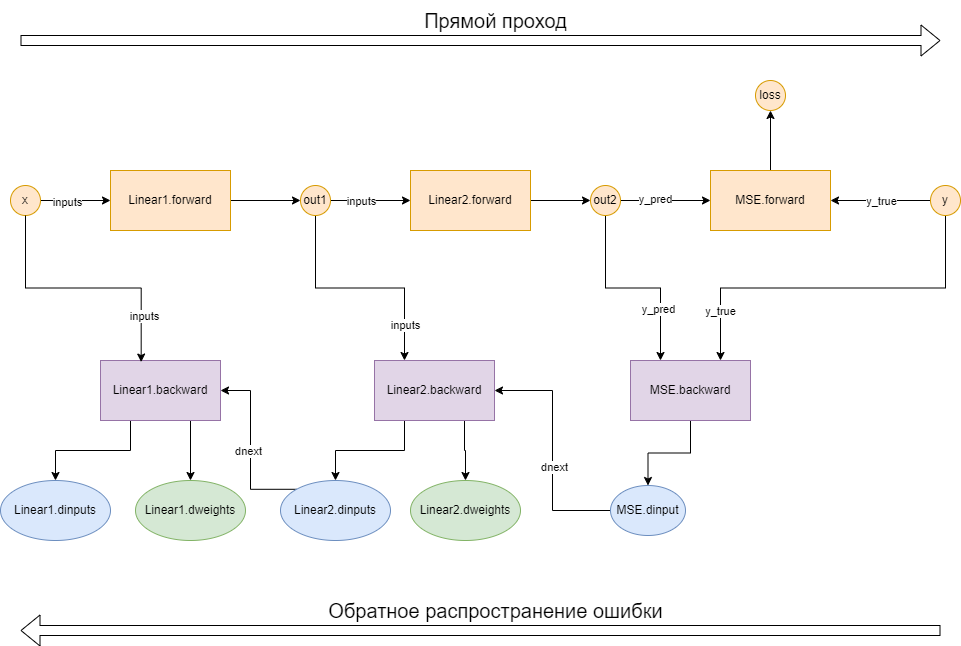

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="deep", font_scale=1.1)

In [45]:
th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

In [46]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)
linear10 = Linear(n_features=1, n_neurons=10, grad=True, lr=0.01)
linear1 = Linear(n_features=10, n_neurons=1, grad=True, lr=0.01)
criterion = MSELoss()

In [47]:
for epoch in range(500):
    losses = []
    for X, y in dataloader:
        y_pred_10 = linear10(X)
        y_pred_1 = linear1(y_pred_10)
        loss_i = criterion.forward(y_pred_1, y)
        losses.append(loss_i.item())

        dinput = criterion.backward(y_pred_1, y)
        dinput = linear1.backward(y_pred_10, dinput)
        dinput = linear10.backward(X, dinput)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {np.mean(losses):.6f}')

Epoch 0, Loss: 1.678724
Epoch 100, Loss: 0.097611
Epoch 200, Loss: 0.097595
Epoch 300, Loss: 0.097761
Epoch 400, Loss: 0.097768


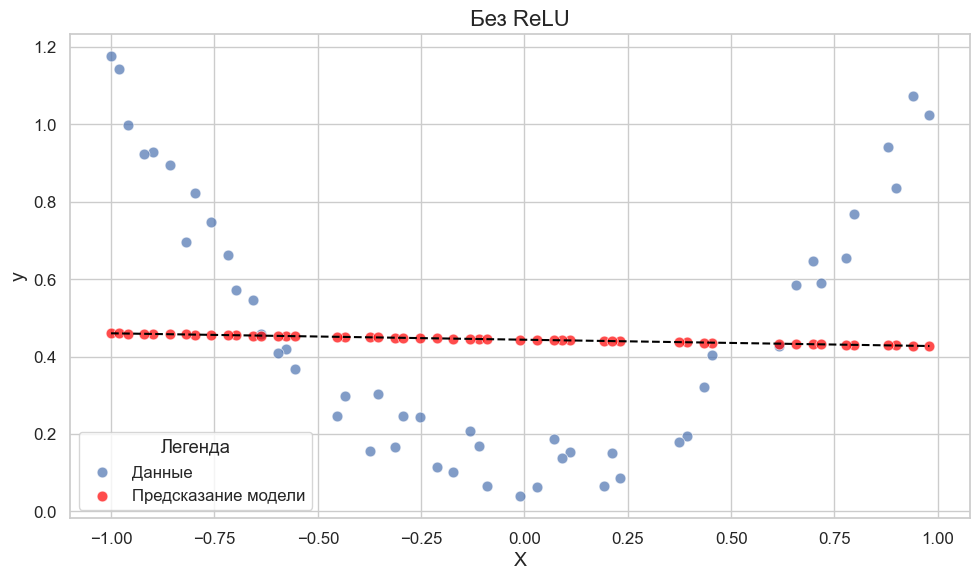

In [48]:
X_np = X.numpy().flatten()
y_np = y.numpy().flatten()

plt.figure(figsize=(10, 6))
plt.title('Без ReLU', fontsize=16)

with th.no_grad():
    y_pred = linear1(linear10(X))
y_pred_np = y_pred.numpy().flatten()

ix = np.argsort(X_np)
sns.scatterplot(x=X_np, y=y_np, label='Данные', s=60, edgecolor='w', alpha=0.7)
sns.scatterplot(x=X_np, y=y_pred_np, color='red', label='Предсказание модели', s=60, edgecolor='w', alpha=0.7)
sns.lineplot(x=X_np[ix], y=y_pred_np[ix], color='black', linestyle='--')

plt.xlabel('X', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.legend(title='Легенда')
plt.tight_layout()
plt.show()

<p class="task" id="6"></p>

6\. Модель из предыдущей задачи является линейной и не способна качественно предсказать искомую зависимость. Для того, чтобы сделать модель нелинейной, в нейронных сетях используются функции активации. Для того, чтобы встроить такую функцию в процесс обратного распространения ошибки, необходимо реализовать соответствующий слой с методами `forward` и `backward`.

$$
f(x) = \max(0, x)
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f}\frac{\partial f}{\partial x} = \frac{\partial L}{\partial f}
\begin{cases}
1 & \text{если } x \ge 0 \\
0 & \text{если } x <  0
\end{cases}
$$

Здесь $L$ - это функция (слой), следующая за ReLU в потоке вычислений.

Реализуйте и обучите модель, состояющую из двух полносвязных слоев, разделенных функцией активации ReLU:
1. Полносвязный слой с 10 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

- [ ] Проверено на семинаре

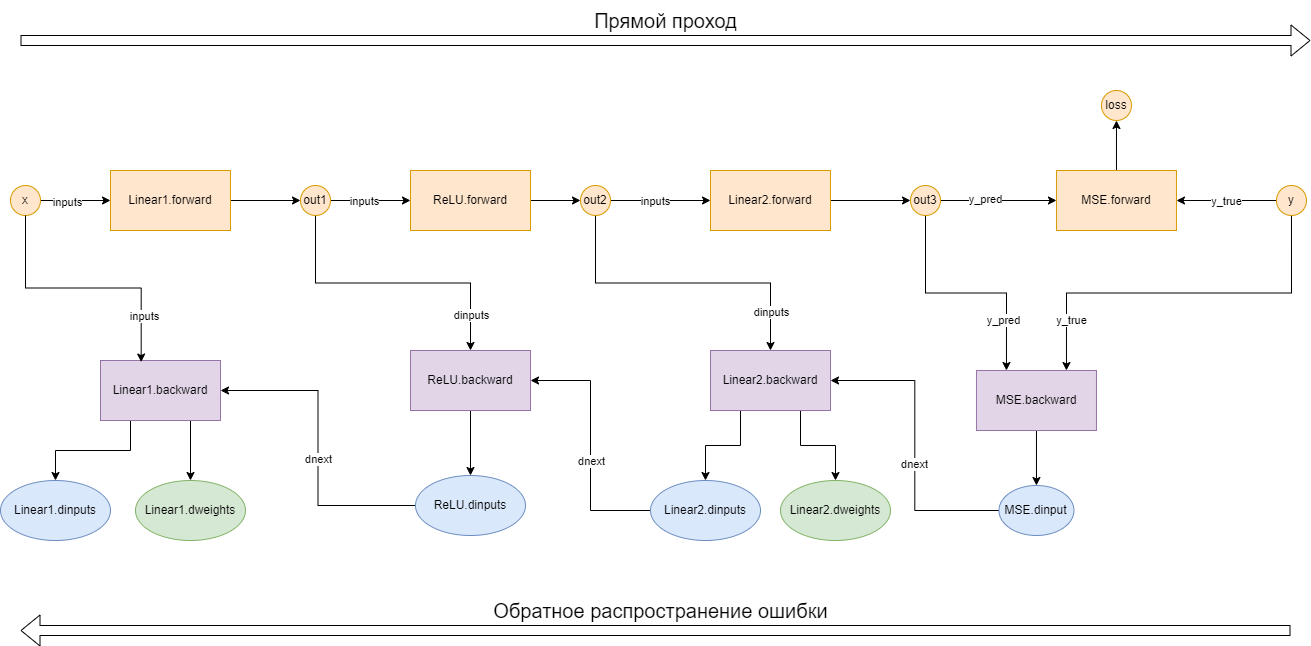

In [49]:
class ReLU:
    def forward(self, inputs: TensorType["batch", "n_features"]) -> TensorType["batch", "n_features"]:
        return inputs.clip(min=0)

    def backward(
        self,
        inputs: TensorType["batch", "n_features"],
        dvalues: TensorType["batch", "n_features"]
    ) -> TensorType["batch", "n_features"]:
        return (inputs >= 0).float() * dvalues
    
    def __call__(self, *args: th.Any, **kwds: th.Any) -> th.Any:
        return self.forward(*args, **kwds)

In [50]:
th.manual_seed(42)
X = th.linspace(-1, 1, 100).view(-1, 1)
y = X.pow(2) + 0.2 * th.rand(X.size())

In [51]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)
linear10 = Linear(n_features=1, n_neurons=10, grad=True, lr=0.01)
linear1 = Linear(n_features=10, n_neurons=1, grad=True, lr=0.01)
criterion = MSELoss()
relu = ReLU()

In [52]:
saved_predictions = {}
save_epochs = [0, 100, 250, 500, 1000, 2500, 4950, 7950]
for epoch in range(8000):
    losses = []
    for X_d, y_d in dataloader:
        y_pred_10 = linear10(X_d)
        y_pred_10_relu = relu.forward(y_pred_10)
        y_pred_1 = linear1(y_pred_10_relu)
        loss_i = criterion.forward(y_pred_1, y_d)
        losses.append(loss_i.item())

        dinput = criterion.backward(y_pred_1, y_d)
        dinput = linear1.backward(y_pred_10_relu, dinput)
        dinput = relu.backward(y_pred_10, dinput)
        dinput = linear10.backward(X_d, dinput)

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {np.mean(losses):.6f}')
    
    if epoch in save_epochs:
        with th.no_grad():
            y_pred = linear1(relu(linear10(X)))
            saved_predictions[epoch] = y_pred.numpy().flatten()

Epoch 0, Loss: 1.668369
Epoch 500, Loss: 0.013681
Epoch 1000, Loss: 0.008503
Epoch 1500, Loss: 0.007412
Epoch 2000, Loss: 0.006817
Epoch 2500, Loss: 0.006301
Epoch 3000, Loss: 0.005761
Epoch 3500, Loss: 0.005207
Epoch 4000, Loss: 0.004747
Epoch 4500, Loss: 0.004417
Epoch 5000, Loss: 0.004192
Epoch 5500, Loss: 0.004014
Epoch 6000, Loss: 0.003897
Epoch 6500, Loss: 0.003797
Epoch 7000, Loss: 0.003696
Epoch 7500, Loss: 0.003613


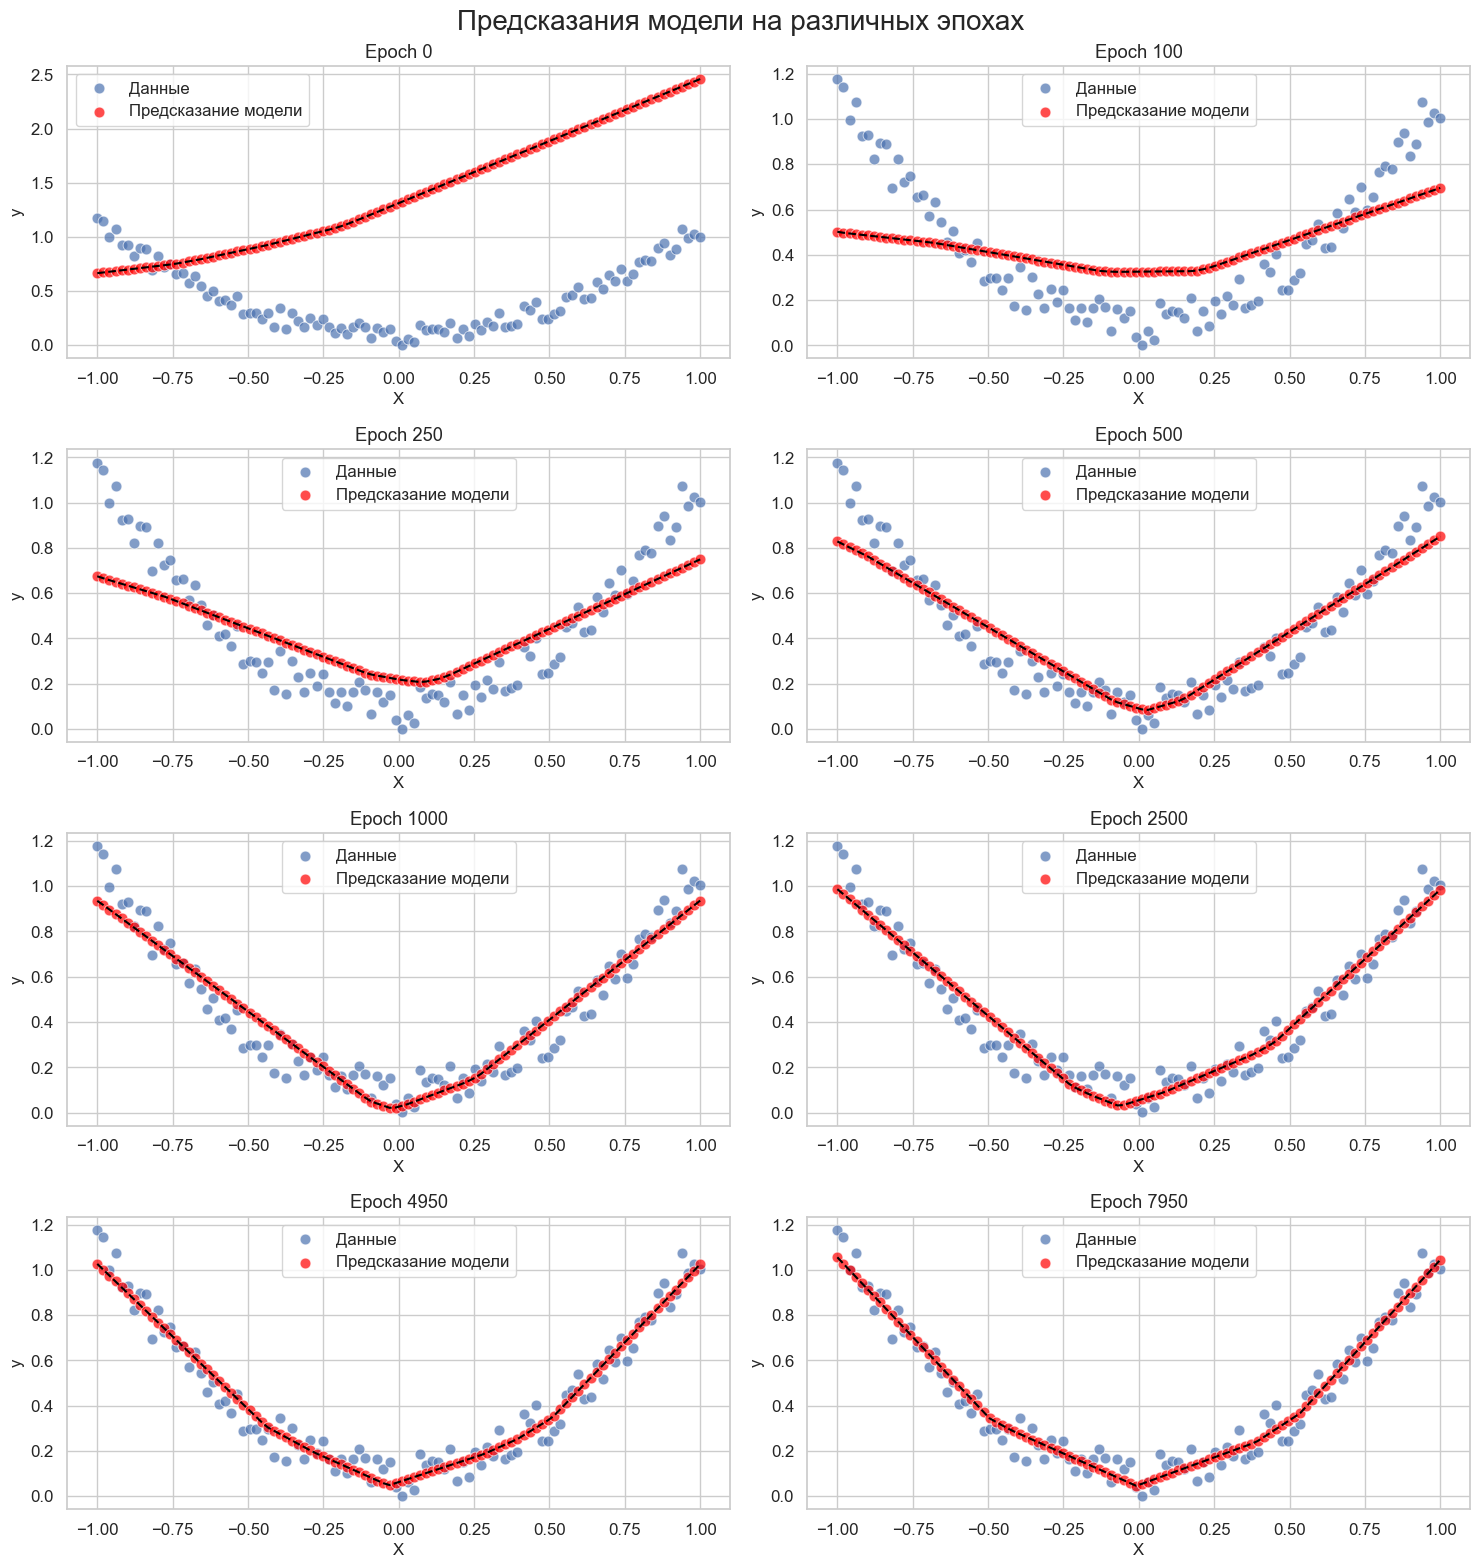

In [53]:
X_np = X.numpy().flatten()
y_np = y.numpy().flatten()

cols = 2
rows = (len(save_epochs) + 1) // cols

plt.figure(figsize=(15, rows * 4))
plt.suptitle('Предсказания модели на различных эпохах', fontsize=20)

for idx, epoch in enumerate(save_epochs):
    plt.subplot(rows, cols, idx + 1)
    y_pred_np = saved_predictions[epoch]
    
    ix = np.argsort(X_np)
    sns.scatterplot(x=X_np, y=y_np, label='Данные', s=60, edgecolor='w', alpha=0.7)
    sns.scatterplot(x=X_np, y=y_pred_np, color='red', label='Предсказание модели', s=60, edgecolor='w', alpha=0.7)
    sns.lineplot(x=X_np[ix], y=y_pred_np[ix], color='black', linestyle='--')
    
    plt.xlabel('X', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(f'Epoch {epoch}')
    plt.legend()

plt.tight_layout()
plt.show()